In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

In [54]:
def prep_input(data,positions,npix=3):
    '''
    Prepare a dataset for processing by flattening the arrays and returning 
    an array of the form: [nsamples, nfeatures]
    
    Currently will not work near edges
    
    Inputs
    ------
    data - input 2D array of data
    positions - central pixel of the data [npoints, positions]
    
    Keywords
    ------
    npix - the box size for extraction (default: 3)
    
    '''
    s = np.shape(positions)
    data_shape = np.shape(data)
    nfeatures = npix*npix
    outarr = np.ones((s[0],nfeatures))
    
    # need to account for odd vs even npix for subscripting
    if (npix % 2) == 0:
        extra = 0
    else:
        extra = 1
        
    for i in np.arange(s[0]):
        pos = positions[i,:]
        pos = np.flip(pos,axis=0) # this takes care of the weird python flip of arrays
        if (pos[0] > int(npix/2)) & (pos[0] < data_shape[0]-int(npix/2)+extra) & \
           (pos[1] > int(npix/2)) & (pos[1] < data_shape[1]-int(npix/2)+extra):
                subarr = data[pos[0]-int(npix/2):pos[0]+int(npix/2)+extra,
                              pos[1]-int(npix/2):pos[1]+int(npix/2)+extra]
                
                #subarr = subarr/np.median(subarr)
                outarr[i,:] = subarr.flatten()
    return outarr
            
            
            
            

In [13]:
hdu = fits.open('/u/tdo/osiris/drs_me/tests/test_emission_line/s150531_a025001.fits')
data = hdu[0].data
print(data[1525,842])

0.253609


In [55]:
x,y,cosmic = np.loadtxt('mask/badpixels.txt',unpack=True,dtype=int)
for i in np.arange(len(x)):
    print(x[i],y[i],cosmic[i],data[y[i],x[i]])

47 2019 1 4.13523
87 2008 0 0.0762438
111 2021 1 1.01795
112 2021 1 45.6858
113 2021 1 0.417272
743 1495 0 0.0554285
752 1495 0 0.0448883
781 1526 0 0.0403521
781 1492 0 0.0700788
774 1557 0 0.0390926
588 1477 0 0.0651828
624 1472 0 0.0722948
671 1441 0 0.0453997
738 1401 0 0.0730145
1023 1540 0 0.044519
1024 1602 0 0.0299634
875 1613 0 0.0893221
843 1525 1 11.824
883 1555 1 37.6068
886 1612 1 0.338935
891 1614 1 51.8197
833 1602 1 26.8241
818 1603 1 11.0159
858 1495 1 34.1969
839 1496 1 5.62841
951 1402 1 11.1033
950 1404 1 6.49746
1833 327 1 0.988149
651 1494 0 0.0653059
673 1493 0 0.237899
657 1502 0 0.0629005
667 1500 0 0.0651733
638 1511 1 2.32374
627 1498 1 1.00945
590 1498 1 0.658627
580 1481 1 1.37421
565 1524 1 0.730799


In [56]:
arr = np.transpose(np.array([x,y]))

training = prep_input(data,arr)
training[0:3,:]

array([[  0.04779563,   0.08932205,   0.06393269,   0.14738329,
          4.13522673,   0.10275067,   0.05587364,   0.09025013,
          0.05950069],
       [  0.09740005,   0.08869702,   0.08451124,   0.06461454,
          0.07624383,   0.07735184,   0.07060912,   0.07846931,
          0.08435025],
       [  0.04659293,   0.07197282,   0.4809489 ,   0.0694443 ,
          1.01795137,  45.6857605 ,   0.05350611,   0.05639449,
          0.42256567]])

In [82]:
classifier = RandomForestClassifier(n_estimators=100,max_depth=3)
tree = classifier.fit(training, cosmic)

In [88]:
# cosmic_test.txt is a manually determined set points for testing
test_x,test_y,test_cosmic = np.loadtxt('mask/cosmic_test.txt',unpack=True,dtype=int)
testing = prep_input(data,np.transpose([test_x,test_y]))
print(testing)

ypred = tree.predict(testing)
print(ypred)
print(test_cosmic)

print(metrics.classification_report(ypred, test_cosmic))


[[  7.10826293e-02   2.02584535e-01   7.22948015e-02   3.67279172e-01
    1.70124035e+01   1.64495766e-01   6.07791506e-02   1.74789771e-01
    4.52387035e-02]
 [  6.19534440e-02   1.66531846e-01   1.00089565e-01   2.99965650e-01
    1.30276499e+01   3.99232268e+00   6.67358488e-02   1.55215070e-01
    8.62916186e-02]
 [  5.88093661e-02   6.12242445e-02   5.98226711e-02   4.07025218e-02
    5.26727363e-02   6.52869195e-02   5.53622469e-02   6.16598688e-02
    4.77198735e-02]
 [  4.75778207e-02   1.50328487e-01   6.71619996e-02   2.82010347e-01
    1.25245771e+01   1.65243909e-01   6.20292053e-02   1.45820722e-01
    7.17076510e-02]
 [  6.10916652e-02   5.15079163e-02   4.92066778e-02   6.78154379e-02
    5.71520999e-02   6.15462288e-02   3.77762578e-02   5.41216657e-02
    4.64982279e-02]
 [  5.50876148e-02   5.62619083e-02   6.20765537e-02   6.22564852e-02
    7.08742812e-02   6.73324615e-02   4.44148034e-02   2.07395363e-03
    1.07561484e-01]
 [  5.81085794e-02   6.74745142e-02   7.

In [80]:
def visualize_classifier(model, inX, y, ax=None, cmap='rainbow'):
    # visual just two of the features
    ax = ax or plt.gca()
    
    
    # Plot the training points
    X = np.array([inX[:,0],inX[:,4]]).transpose()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.set_yscale('log')
    #ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

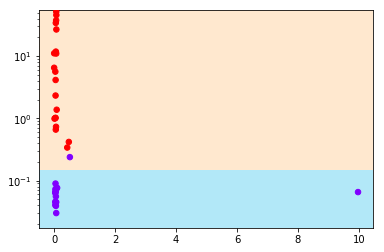

In [79]:
visualize_classifier(classifier,training,cosmic)

In [72]:
np.array([training[:,1],training[:,4]]).transpose()

array([[  8.93220529e-02,   4.13522673e+00],
       [  8.86970237e-02,   7.62438327e-02],
       [  7.19728172e-02,   1.01795137e+00],
       [  4.80948895e-01,   4.56857605e+01],
       [  1.07343666e-01,   4.17271882e-01],
       [  5.71331605e-02,   5.54285385e-02],
       [  5.22371121e-02,   4.48883101e-02],
       [  5.18298969e-02,   4.03521284e-02],
       [  5.41784838e-02,   7.00787976e-02],
       [  5.49929142e-02,   3.90926041e-02],
       [  1.28869221e-01,   6.51827529e-02],
       [  5.81085794e-02,   7.22948015e-02],
       [  3.69239487e-02,   4.53996956e-02],
       [  4.28995863e-02,   7.30145276e-02],
       [  6.86582774e-02,   4.45189737e-02],
       [  4.57974412e-02,   2.99634207e-02],
       [  4.39507701e-02,   8.93220529e-02],
       [  1.37326032e-01,   1.18239784e+01],
       [  3.57941657e-01,   3.76068001e+01],
       [  1.08906239e-01,   3.38935137e-01],
       [  5.09463370e-01,   5.18196907e+01],
       [  2.76887000e-01,   2.68241081e+01],
       [  